In [1]:
import torch

In [5]:
import sys
print(sys.executable)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\python.exe


In [ ]:
!"C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\python.exe" -m pip install optuna



## how to remove the overffting from your model some of the solution :-
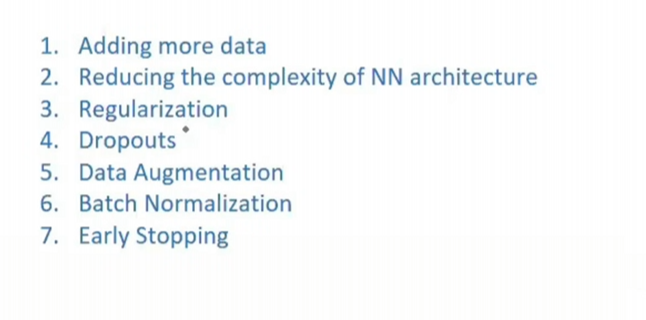

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [9]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

dataset = FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)



100%|██████████| 26.4M/26.4M [03:54<00:00, 113kB/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 44.0kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:50<00:00, 87.5kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.78MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [12]:
import pandas as pd
import torch

data = []
labels = []

for img, label in dataset:
    data.append(img.view(-1).numpy())   # 28×28 → 784
    labels.append(label)

df = pd.DataFrame(data)
df["label"] = labels

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train = X_train/255.0
X_test = X_test/255.0

In [16]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [17]:
train_dataset = CustomDataset(X_train, y_train)

In [18]:
test_dataset = CustomDataset(X_test, y_test)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
print(len(train_loader))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

1500


In [34]:
class MyNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [38]:
leaerning_rate = 0.1 
epochs = 20

In [39]:
model = MyNN(X_train.shape[1])

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

In [40]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.006831260484701488
Epoch: 2 , Loss: 0.000418906166543214
Epoch: 3 , Loss: 0.000271390005199161
Epoch: 4 , Loss: 0.00021587173240065265
Epoch: 5 , Loss: 0.00018765475548813507
Epoch: 6 , Loss: 0.0001725912084026883
Epoch: 7 , Loss: 0.00015571985874218323
Epoch: 8 , Loss: 0.00015337039703202513
Epoch: 9 , Loss: 0.00014691468474969347
Epoch: 10 , Loss: 0.00014865860494198084
Epoch: 11 , Loss: 0.00014219298464013264
Epoch: 12 , Loss: 0.00013786436865969638
Epoch: 13 , Loss: 0.00013678584005780674
Epoch: 14 , Loss: 0.00014148143820784753
Epoch: 15 , Loss: 0.00013537278858954474
Epoch: 16 , Loss: 0.00013536025588594688
Epoch: 17 , Loss: 0.00013533369640693612
Epoch: 18 , Loss: 0.0001390264876730119
Epoch: 19 , Loss: 0.00014039907225621087
Epoch: 20 , Loss: 0.0001367125700174559


In [41]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [42]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

1.0


In [43]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

1.0
